In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

#%cd /content/drive/MyDrive/
#!git clone https://github.com/vinotharjun/FaceGrouping.git

#----------------------------------------------------------
#----------------------- install --------------------------
#----------------------------------------------------------
base_folder = '/content/drive/MyDrive/Capstone_FaceRecognition'
%cd {base_folder}

!pip install mtcnn
!pip install -r requirements.txt #embedding & tsne 위한 설치



#----------------------------------------------------------
#----------------------- import  --------------------------
#----------------------------------------------------------
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
from sklearn.cluster import DBSCAN
import os
from sklearn.preprocessing import scale
from tqdm import tqdm
import time



#----------------------------------------------------------
#---------------- file, folder name -----------------------
#----------------------------------------------------------
group_name = 'group0' #여기서 group명
images_folder = base_folder + '/images'
group_folder = images_folder + '/' + group_name
aligned_group_folder = group_folder + '_crop'
path_dict = {}


#----------------------------------------------------------
#---------------- 1. face extraction  ---------------------
#----------------------------------------------------------
# input: 이미지 하나
# MTCNN 적용해서 face detection (alignment는 안됨)
# output : _crop 폴더에 detect한 이미지 crop해서 저장함
def extract_faces(filename, required_size=(112, 112)): #required_size=(160, 160)
    #faces=[]
    image = Image.open(path)
    image = image.convert('RGB')
    pixels = np.asarray(image)

    detector = MTCNN()
    results = detector.detect_faces(pixels)

    if len(results)==0:
      print(filename, " 얼굴 detect 안됨")
      #return faces

    num  = 1
    for i in range(len(results)):
        x1, y1, width, height = results[i]['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        face = pixels[y1:y2, x1:x2]
        image = Image.fromarray(face)
        image = image.resize(required_size)

        #_aligned 폴더에 이미지 저장
        if not os.path.isdir(aligned_group_folder):
          os.mkdir(aligned_group_folder)

        if not os.path.isdir(aligned_group_folder + '/' + user_folder_name):
          os.mkdir(aligned_group_folder + '/' + user_folder_name)

        #if filename.split(".")[-1].lower() not in ["jpg", "jpeg"]:
        save_filename = ".".join(filename.split(".")[:-1]) + "_" + str(num) + ".jpg" 
        num = num + 1
        
        crop_path = os.path.join(aligned_group_folder + '/' + user_folder_name, save_filename) #이제 ec2서버에 저장하는거라 폴더구조 조금 손보기.
        image.save(crop_path)

        #make path callable. {"key": crop_path, "value": 원래 이미지 path} (나중엔 value는 url이 되겠지.)
        path_dict[crop_path] = path

        #faces vector에 append (여기도 이제 없애됨됨)
        #faces.append(np.asarray(image)) 

    #return faces #(리턴값 없어도됨)



#----------------------------------------------------------
#------------------- 2.  align (미완성)  ------------------
#----------------------------------------------------------



#----------------------------------------------------------
#--------------- 3. Face Embedding(ArcFace) ---------------
#----------------------------------------------------------
# input: data_root
# output: 해당 폴더에 들어있는 모든 이미지에 대해 embedding리스트인 embeddings return
# embeddings[[embedding1], [embedding2] ... [embeddingN]] 
import os
import cv2
import numpy as np
import torch
import torch.utils.data as data
import torchvision.datasets as datasets
import torch.nn.functional as F
import torchvision.transforms as transforms
from backbone import Backbone
from tqdm import tqdm

def get_embeddings(data_root, model_root, input_size=[112, 112], embedding_size=512):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # data & model 경로
    assert os.path.exists(data_root)
    assert os.path.exists(model_root)
    print(f"Data root: {data_root}")

    # define image preprocessing
    transform = transforms.Compose(
        [
            transforms.Resize(
                [int(128 * input_size[0] / 112), int(128 * input_size[0] / 112)],
            ),  # smaller side resized
            transforms.CenterCrop([input_size[0], input_size[1]]),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ],
    )

    # define data loader
    dataset = datasets.ImageFolder(data_root, transform)
    loader = data.DataLoader(
        dataset, batch_size=1, shuffle=False, pin_memory=True, num_workers=0,
    )
    print(f"Number of classes: {len(loader.dataset.classes)}")

    # load backbone weigths from a checkpoint
    backbone = Backbone(input_size)
    backbone.load_state_dict(torch.load(model_root, map_location=torch.device("cpu")))
    backbone.to(device)
    backbone.eval()

    # get embedding for each face
    embeddings = np.zeros([len(loader.dataset), embedding_size])
    with torch.no_grad():
        for idx, (image, _) in enumerate(
            tqdm(loader, desc="Create embeddings matrix", total=len(loader)),
        ):
            embeddings[idx, :] = F.normalize(backbone(image.to(device))).cpu()

    # all_faces 에 path, face 등 저장
    all_faces = []
    i = 0
    for crop_path, _ in dataset.samples:
      face = cv2.imread(crop_path)
      all_faces.append({
          "crop_path":crop_path, 
          "face_idx" : i,
          "face":face
          })
      i = i + 1

    return all_faces, embeddings

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Capstone_FaceRecognition
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.3.0.tar.gz (38.8 MB)
  Preparing metadata (setup.py) ... done
  Using cached numpy-1.19.0.zip (7.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement opencv-python==4.3.0.36 (from versions: 3.4.0.14, 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.14.51, 3.4.14.53, 3.4.15.55, 3.4.16.57, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.2.52, 4.5.2.54, 4.5.3.56, 

In [ ]:
#----------------------------------------------------------
#-------------------- 실행!!! face detect -----------------
#----------------------------------------------------------
#all_faces=[]
input_size = 112
#file_idx = 0
#global_face_idx = 0

for user_folder_name in tqdm(os.listdir(group_folder)):
  user_folder = group_folder + '/' + user_folder_name
  for filename in os.listdir(user_folder):
    path = user_folder + '/' + filename
    #faces = extract_faces(filename)
    extract_faces(filename)

#print(len(all_faces))


#----------------------------------------------------------
#---------------------- 실행!!! embedding -----------------
#----------------------------------------------------------
all_faces, embeddings = get_embeddings(
        data_root=f"/content/drive/MyDrive/Capstone_FaceRecognition/images/{group_name}_crop" ,
        model_root="checkpoint/backbone_ir50_ms1m_epoch120.pth",
        input_size=[input_size, input_size],
)

print("embeddings 길이 = ", len(embeddings)) 

#all_faces에 embeddings 넣기
for i in range(len(embeddings)):
  all_faces[i]["embedding"] = embeddings[i]


#----------------------------------------------------------
#-------------- 실행!!! cos_similarity 계산 ---------------
#----------------------------------------------------------
#cos_similarity[i][j]로 접근 가능.
cos_similarity = np.dot(embeddings, embeddings.T)
cos_similarity = cos_similarity.clip(min=0, max=1)

  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 241ms/step


 50%|█████     | 1/2 [00:16<00:16, 16.41s/it]

1/1 [==============================] - 0s 179ms/step


100%|██████████| 2/2 [00:40<00:00, 20.48s/it]

/content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop
Data root: /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop
Number of classes: 2



Create embeddings matrix: 100%|██████████| 40/40 [00:12<00:00,  3.08it/s]


embeddings 길이 =  40


0


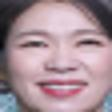

1


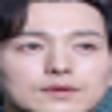

2


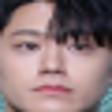

3


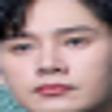

4


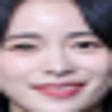

5


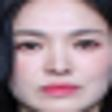

6


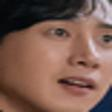

7


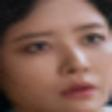

8


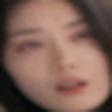

9


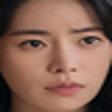

10


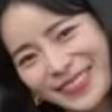

11


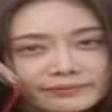

12


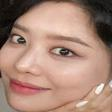

13


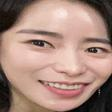

14


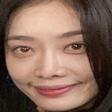

15


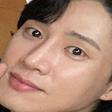

16


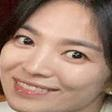

17


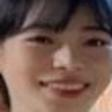

18


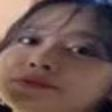

19


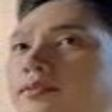

20


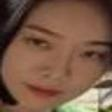

21


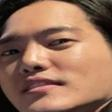

22


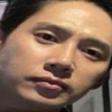

23


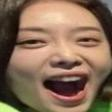

24


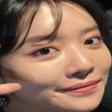

25


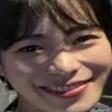

26


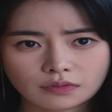

27


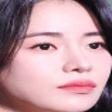

28


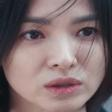

29


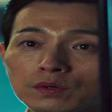

30


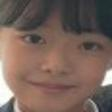

31


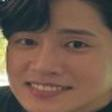

32


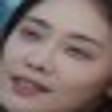

33


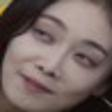

34


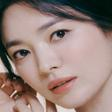

35


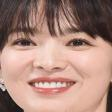

36


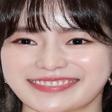

37


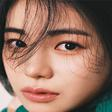

38


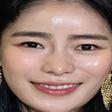

39


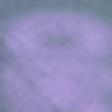

In [ ]:
'''
#all_faces 순서 확인
from google.colab.patches import cv2_imshow

for i in range(len(all_faces)):
  print(i)
  img_test = all_faces[i]["face"]
  cv2_imshow(img_test)
'''

In [ ]:
#----------------------------------------------------------
#---------------------- 실행!!! grouping ------------------
#----------------------------------------------------------
#face1 : 비교기준이 되는 이미지
#face2 : 지금 새로 그룹을 부여할 이미지
cos_distance_threshold = 0.45 ###여기 정해야함
group_list = []
is_already_in_group = False

for face2_idx in range(len(all_faces)): # 해당 얼굴에 대해
    is_already_in_group = False

    # Case1 : 기존 그룹 탐색
    for group_list_idx in range(len(group_list)): #각 그룹마다
      for i in range(len(group_list[group_list_idx]["face2_idx_list"])): #그 그룹에 들어있는 얼굴마다
        face1_idx = group_list[group_list_idx]["face2_idx_list"][i]
        cosine_distance = cos_similarity[face1_idx][face2_idx]

        if( not is_already_in_group and cosine_distance > cos_distance_threshold ) :
          crop_path = all_faces[face2_idx]["crop_path"]
          group_list[group_list_idx]["original_path_list"].append(path_dict[crop_path]) #dictionary에서 원래 path 찾아넣기
          group_list[group_list_idx]["crop_path_list"].append(crop_path)
          group_list[group_list_idx]["face_list"].append(all_faces[face2_idx]["face"])
          group_list[group_list_idx]["face2_idx_list"].append(face2_idx)
          group_list[group_list_idx]["face1_idx_list"].append(face1_idx)
          group_list[group_list_idx]["cosine_distance_list"].append(cosine_distance)

          all_faces[face2_idx]["group_idx"] = group_list_idx

          is_already_in_group = True
          

    # Case2 : 못 넣었으면 새로운 그룹에 추가
    if not is_already_in_group :
      all_faces[face2_idx]["group_idx"] = len(group_list)
      crop_path = all_faces[face2_idx]["crop_path"]
      group_list.append ({
          "original_path_list" : [path_dict[crop_path]], #dictionary에서 원래 path 찾아넣기
          "crop_path_list" : [crop_path],
          "face_list" : [all_faces[face2_idx]["face"]],
          "face2_idx_list" : [face2_idx], 
          "face1_idx_list" : [[]],
          "cosine_distance_list" : [-1]
      })

print(len(group_list))

26


group =  0
0
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory0_1.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory0.jpg


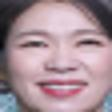

group =  1
1
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory0_2.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory0.jpg


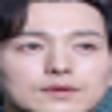

group =  2
2
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory0_3.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory0.jpg


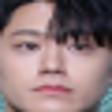

group =  3
3
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory0_4.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory0.jpg


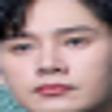

group =  4
4
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory0_5.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory0.jpg


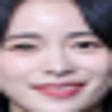

9
0.48107619537737556
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory10_4.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory10.jpg


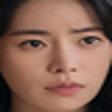

13
0.7011213491150388
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory1_2.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory1.jpg


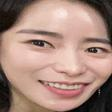

25
0.475752016499303
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory3_5.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory3.jpg


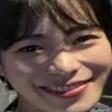

26
0.8661469778789499
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory4_1.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory4.jpg


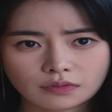

27
0.4974698240494337
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory5_1.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory5.jpg


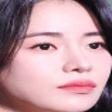

36
0.5747384541255894
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user2/yeon1_1.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user2/yeon1.jpg


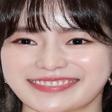

37
0.47186708885185535
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user2/yeon2_1.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user2/yeon2.jpg


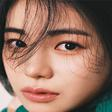

38
0.5753603830263057
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user2/yeon_1.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user2/yeon.jpg


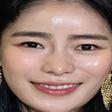

group =  5
5
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory0_6.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory0.jpg


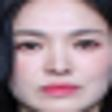

34
0.46106462414518
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user2/kyo2_1.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user2/kyo2.jpg


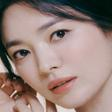

35
0.48668307125484833
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user2/kyo_1.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user2/kyo.jpg


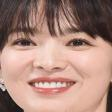

group =  6
6
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory10_1.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory10.jpg


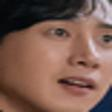

group =  7
7
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory10_2.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory10.jpg


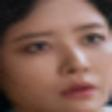

group =  8
8
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory10_3.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory10.jpg


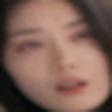

11
0.4893111791717736
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory11_2.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory11.jpg


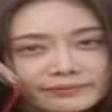

14
0.6455167143403274
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory1_3.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory1.jpg


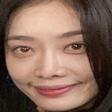

23
0.45605058163177625
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory3_3.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory3.jpg


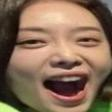

group =  9
10
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory11_1.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory11.jpg


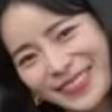

group =  10
12
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory1_1.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory1.jpg


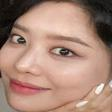

group =  11
15
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory1_4.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory1.jpg


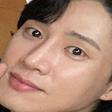

group =  12
16
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory1_5.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory1.jpg


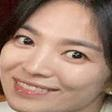

group =  13
17
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory2_1.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory2.jpg


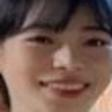

group =  14
18
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory2_2.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory2.jpg


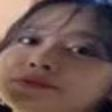

group =  15
19
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory2_3.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory2.jpg


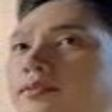

22
0.5473345977431249
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory3_2.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory3.jpg


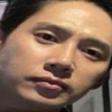

group =  16
20
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory2_4.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory2.jpg


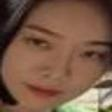

group =  17
21
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory3_1.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory3.jpg


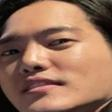

group =  18
24
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory3_4.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory3.jpg


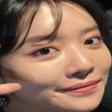

group =  19
28
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory6_1.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory6.jpg


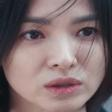

group =  20
29
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory7_1.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory7.jpg


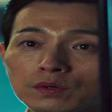

group =  21
30
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory8_1.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory8.jpg


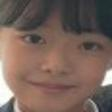

group =  22
31
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory8_2.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory8.jpg


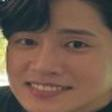

group =  23
32
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory9_1.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory9.jpg


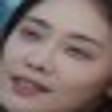

group =  24
33
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user1/glory9_2.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory9.jpg


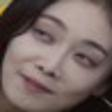

group =  25
39
-1
crop_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0_crop/user2/yeon_2.jpg
original_path =  /content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user2/yeon.jpg


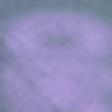

In [ ]:
#grouping 잘됐나 테스트
from google.colab.patches import cv2_imshow

for i in range(len(group_list)):
  print("======================================================")
  print("group = ", i )
  for j in range(len(group_list[i]["face_list"])):
    print(group_list[i]["face2_idx_list"][j]) #face idx
    print(group_list[i]["cosine_distance_list"][j]) #cosine distance
    #cv2_imshow(group_list[i]["face_list"][j]) #face

    #path 잘 들어갔나 확인인   
    crop_path = group_list[i]["crop_path_list"][j]
    original_path = group_list[i]["original_path_list"][j]
    print("crop_path = ", crop_path)
    print("original_path = ", original_path)
    cv2_imshow(cv2.imread(crop_path)) 

group idx =  0
group idx =  1
group idx =  2
group idx =  3
group idx =  6
group idx =  7
group idx =  9
group idx =  10
group idx =  11
group idx =  12
group idx =  13
group idx =  14
group idx =  16
group idx =  17
group idx =  18
group idx =  19
group idx =  20
group idx =  21
group idx =  22
group idx =  23
group idx =  24
group idx =  25
all faces idx =  0
group_idx =  0


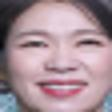

all faces idx =  1
group_idx =  0


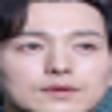

all faces idx =  2
group_idx =  0


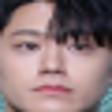

all faces idx =  3
group_idx =  0


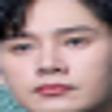

all faces idx =  4
group_idx =  4


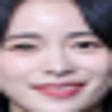

all faces idx =  5
group_idx =  5


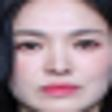

all faces idx =  6
group_idx =  0


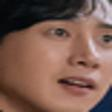

all faces idx =  7
group_idx =  0


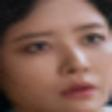

all faces idx =  8
group_idx =  8


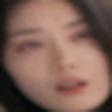

all faces idx =  9
group_idx =  4


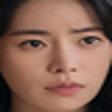

all faces idx =  10
group_idx =  0


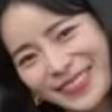

all faces idx =  11
group_idx =  8


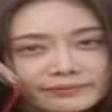

all faces idx =  12
group_idx =  0


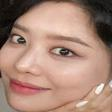

all faces idx =  13
group_idx =  4


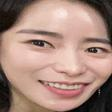

all faces idx =  14
group_idx =  8


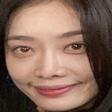

all faces idx =  15
group_idx =  0


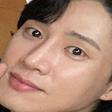

all faces idx =  16
group_idx =  0


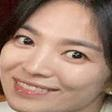

all faces idx =  17
group_idx =  0


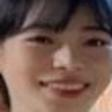

all faces idx =  18
group_idx =  0


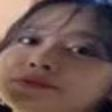

all faces idx =  19
group_idx =  15


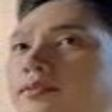

all faces idx =  20
group_idx =  0


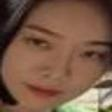

all faces idx =  21
group_idx =  0


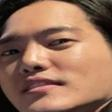

all faces idx =  22
group_idx =  15


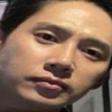

all faces idx =  23
group_idx =  8


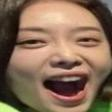

all faces idx =  24
group_idx =  0


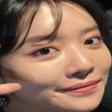

all faces idx =  25
group_idx =  4


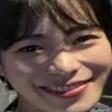

all faces idx =  26
group_idx =  4


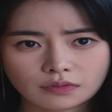

all faces idx =  27
group_idx =  4


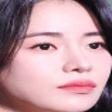

all faces idx =  28
group_idx =  0


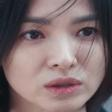

all faces idx =  29
group_idx =  0


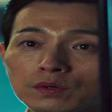

all faces idx =  30
group_idx =  0


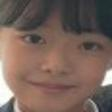

all faces idx =  31
group_idx =  0


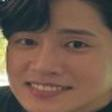

all faces idx =  32
group_idx =  0


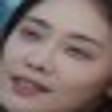

all faces idx =  33
group_idx =  0


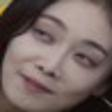

all faces idx =  34
group_idx =  5


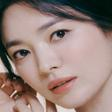

all faces idx =  35
group_idx =  5


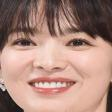

all faces idx =  36
group_idx =  4


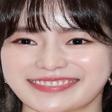

all faces idx =  37
group_idx =  4


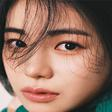

all faces idx =  38
group_idx =  4


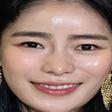

all faces idx =  39
group_idx =  0


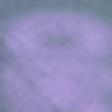

In [ ]:
# group len이 1인건 group index 0 으로 변경
for i in range(len(group_list)):
  if len(group_list[i]["face2_idx_list"]) == 1 :
    print("group idx = ", i)
    face_idx = group_list[i]["face2_idx_list"][0]
    all_faces[face_idx]["group_idx"] = 0

#최종으로 넘길 값 잘 넘어갔나 확인
for i in range(len(all_faces)):
    print("all faces idx = ", all_faces[i]["face_idx"])
    print("group_idx = ", all_faces[i]["group_idx"])
    cv2_imshow(cv2.imread(all_faces[i]["crop_path"])) 

### 최종 실행함수 (미완)

In [ ]:
#----------------------------------------------------------
#----------------------- 최종 함수 ------------------------
#----------------------------------------------------------
def image_indexing(images_list, num_of_users):
  yolo_result = []
  face_result = []

  for image in images_list :
    image_id = image["id"]
    image_url = image["url"]

    #1. YOLOv5 
    tag1 = yolov5(image_url) #input이 image 한장이고, output이 tag인 함수 호출.
    yolo_result.append({"image_id": "2","tag": "바다 산"}) #tag : "바다 산"

    #2. FaceRecognition
    tag2 = face_recognition(image_url) #input이 image 한장이고 output이 tag(하나의 사진이 속하는 group 목록 나열)인 함수 호출.
    face_result.append({"group_id": "1", "images" : ["url1", "url2"...]})

    #3. result에 append
    tag = tag1 + " " + tag2
    image_result.append({"id" : image_id, "tag" : tag}) 

  return image_result

### 기타 코드들

In [ ]:
import argparse
import os
import cv2
import numpy as np


def visualize_similarity(tag, input_size=[112, 112]):
    

    # calculate cosine similarity matrix
    cos_similarity = np.dot(embeddings, embeddings.T)
    cos_similarity = cos_similarity.clip(min=0, max=1)
    # plot colorful grid from pair distance values in similarity matrix
    similarity_grid = plot_similarity_grid(cos_similarity, input_size)

    # pad similarity grid with images of faces
    horizontal_grid = np.hstack(images)
    vertical_grid = np.vstack(images)
    zeros = np.zeros((*input_size, 3))
    vertical_grid = np.vstack((zeros, vertical_grid))
    result = np.vstack((horizontal_grid, similarity_grid))
    result = np.hstack((vertical_grid, result))

    if not os.path.isdir("images"):
        os.mkdir("images")

    cv2.imwrite(f"images/{tag}.jpg", result)


def plot_similarity_grid(cos_similarity, input_size):
    n = len(cos_similarity)
    rows = []
    for i in range(n):
        row = []
        for j in range(n):
            # create small colorful image from value in distance matrix
            value = cos_similarity[i][j]
            cell = np.empty(input_size)
            cell.fill(value)
            cell = (cell * 255).astype(np.uint8)
            # color depends on value: blue is closer to 0, green is closer to 1
            img = cv2.applyColorMap(cell, cv2.COLORMAP_WINTER)

            # add distance value as text centered on image
            font = cv2.FONT_HERSHEY_SIMPLEX
            text = f"{value:.2f}"
            textsize = cv2.getTextSize(text, font, 1, 2)[0]
            text_x = (img.shape[1] - textsize[0]) // 2
            text_y = (img.shape[0] + textsize[1]) // 2
            cv2.putText(
                img, text, (text_x, text_y), font, 1, (255, 255, 255), 2, cv2.LINE_AA,
            )
            row.append(img)
        rows.append(np.concatenate(row, axis=1))
    grid = np.concatenate(rows)
    return grid

visualize_similarity("group0")  

5


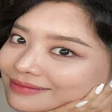

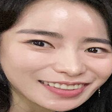

In [ ]:
print(len(all_faces[4]["face_list"]))

for i in range(all_faces[15]["count"]):
  img_test = Image.fromarray(all_faces[4]["face_list"][i]) 
  img_test.show()

5


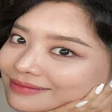

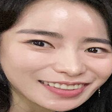

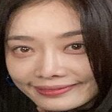

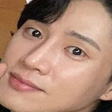

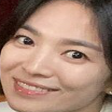

In [ ]:
#all_faces.append({"id": path,"face_list":faces, "count":len(faces)}) 일때
print(len(all_faces[4]["face_list"]))

for i in range(len(all_faces[4]["face_list"])):
  img_test = Image.fromarray(all_faces[4]["face_list"][i]) 
  img_test.show()

In [ ]:
len(embeddings)

In [ ]:
len(embeddings[0])

In [ ]:
len(all_faces)

In [ ]:
cos_similarity[0][0]

In [ ]:
cos_similarity[4][9]

In [ ]:
cos_similarity[4][16]

In [ ]:
cos_similarity[16][4]

In [ ]:
group_list = face_grouping()

print(len(group_list))

print(group_list)

for group in group_list:
  print(len(group["images"]))
  print(group["images"])
  print("==========")

time2=time.time()
print("face extraction time = ", str(time2-time1))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
group_list 초기화 진행
여기실행2
temp= 0
temp= 1


IndexError: ignored

In [ ]:
#all_faces[0]["face_list"]
all_faces[14]["count"]

4

In [ ]:
all_faces[14]["id"]

'/content/drive/MyDrive/Capstone_FaceRecognition/images/group0/user1/glory10.jpg'

In [ ]:
len(all_faces[14]["face_embeddings"])

4